# EXPLORATION AND FEATURE ENGINEERING
### STARCRAFT II

In [410]:
import json
import numpy as np
import os
from pathlib import Path
import pandas as pd
from ast import literal_eval
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_extraction import FeatureHasher
# from sentence_transformers import SentenceTransformer
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import math
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})

### DATA CREATION

In [249]:
import sc2reader
from sc2reader.engine.plugins import APMTracker, ContextLoader, SelectionTracker
from sc2reader.events import PlayerStatsEvent, UnitBornEvent, UnitDiedEvent, UnitDoneEvent, UnitTypeChangeEvent, UpgradeCompleteEvent

try:
    replay_file = "ASUS ROG Fall 2021 Replays/Group Stage/Group A/2 - HeRoMaRinE vs Zest/21-09-17 14_57_35 - Oxide LE - [mouz]HeroMarine vs DPGZest.SC2Replay"

except NameError:
    print('\n'
          'SETUP ERROR: Please follow the directions to add a .SC2Replay file and use\n'
          '             "Insert to code" to set the streaming_body_1 variable to the resulting bytes.\n'
          '             You may need to rename the data_* variable.')
    raise

replay = sc2reader.load_replay(
    replay_file,
    engine=sc2reader.engine.GameEngine(plugins=[ContextLoader(), APMTracker(), SelectionTracker()]))

print("Replay successfully loaded.")

Replay successfully loaded.


In [250]:
print("Date: %s" % replay.date)
print("Map Name: " + replay.map_name)
for player in replay.players:
    print("%s: %s" % (player.result, player))

Date: 2021-09-17 11:57:36
Map Name: Oxide LE
Loss: Player 1 - HeroMarine (Terran)
Win: Player 2 - DPGZest (Protoss)


In [ ]:
data_dir = Path('replay_data/DH SC2 Masters - Atlanta 2022')
# for tournament in data_dir.glob('*'):
for folder in data_dir.glob('*'):
    # if folder.name not in ['5 - Latin America', '6 - Oceanic - RoA']: continue
    for group in folder.glob('*'):
        # for match in group.glob('*'):
        for file in group.glob('*'):
            if file.name.split('.')[-1] != 'SC2Replay':  continue
            replay = sc2reader.load_replay(
            str(file),
            engine=sc2reader.engine.GameEngine(plugins=[ContextLoader(), APMTracker(), SelectionTracker()]))
            record = {
                'map' : replay.map_name,
                'player_1_units' : [unit.name for unit in replay.players[0].units],
                'player_1' : replay.players[0].name,
                'player_2_units' : [unit.name for unit in replay.players[1].units],
                'player_2' : replay.players[1].name,
                'winner' : 1 if replay.players[0].result == 'Win' else 2,
                'build' : replay.build,
                'path' : str(file)
            }
            
            final_df = pd.concat([final_df, pd.json_normalize(record)], ignore_index=True)


#### Helper Functions

In [411]:
def plot_numeric(data, numeric_features, target) :
    # Looping through and Plotting Numeric features
    for column in numeric_features:    
        # Figure initiation
        fig = plt.figure(figsize=(12,6))

        ### Distribution plot
        sns.distplot(data[column], ax=plt.subplot(221))
        plt.xlabel(column, fontsize=10)
        plt.ylabel('Density', fontsize=10)
        plt.suptitle('Plots for '+column, fontsize=10)

        ### Distribution per Positive / Negative class Value
        classes = data[target].unique()
        sns.distplot(data.loc[data[target]==classes[0], column].dropna(),
                     color='red', label=str(classes[0]), ax=plt.subplot(222))
        # Survived hist
        sns.distplot(data.loc[data[target]==classes[1], column].dropna(),
                     color='blue', label=str(classes[1]), ax=plt.subplot(222))
        # Adding Legend
        plt.legend(loc='best')
        plt.xlabel(column, fontsize=10)
        plt.ylabel('Density per '+ str(classes[0])+' / '+str(classes[1]), fontsize=10)

        ### Average Column value per positive / Negative Value
        sns.barplot(x=target, y=column, data=data, ax=plt.subplot(223))
        plt.xlabel('Positive or Negative?', fontsize=10)
        plt.ylabel('Average ' + column, fontsize=10)

        ### Boxplot of Column per Positive / Negative class Value
        sns.boxplot(x=target, y=column, data=data, ax=plt.subplot(224))
        
        plt.xlabel('Positive or Negative ?', fontsize=10)
        
        plt.ylabel(column, fontsize=10)
        plt.show()
        
def plot_categ(train_data, target, nominal_features,positive =1) :
    for column in nominal_features:
    # Figure initiation
        fig = plt.figure(figsize=(18,12))
        
        ### Number of occurrences per categoty - target pair
        ax = sns.countplot(x=column, hue=target, data=train_data, ax = plt.subplot(211))
        plt.xlabel(column, fontsize=14)
        plt.ylabel('Number of occurrences', fontsize=14)
        plt.suptitle('Plots for '+column, fontsize=18)
        plt.legend(loc=1)

        ### Adding percents over bars
        height = [p.get_height() if np.isnan(p.get_height()) == 0 else 0 for p in ax.patches] #  get nan if
        ncol = int(len(height)/2)
        total = [height[i] + height[i + ncol] for i in range(ncol)] * 2
        for i, p in enumerate(ax.patches):    
            # Adding percentages
            ax.text(p.get_x()+p.get_width()/2, height[i]*1.01 + 10,
                    '{:1.0%}'.format(height[i]/total[i]), ha="center", size=14) 

        negative = train_data[target].unique()[0] if train_data[target].unique()[0] != positive else train_data[target].unique()[1]
        ### Positive class percentage for every value of feature
        
        sns.pointplot(x=train_data[column], y=train_data[target].map({negative:0 , positive: 1}), ax = plt.subplot(212))
        plt.xlabel(column, fontsize=14)
        plt.ylabel(' Positive class percentage', fontsize=14)
        plt.show()
        
def convert_array(arr):
    return np.array(arr)

def parse_and_count_units(unit_str):
    unit_counts = Counter(unit_str)
    return unit_counts


VESPENE_UNITS = ["Assimilator", "Extractor", "Refinery"]

SUPPLY_UNITS = ["Overlord", "Overseer", "Pylon", "SupplyDepot"]

WORKER_UNITS = ["Drone", "Probe", "SCV", "MULE"]

BASE_UNITS = ["CommandCenter", "Nexus", "Hatchery", "Lair", "Hive", "PlanetaryFortress", "OrbitalCommand"]

GROUND_UNITS = ["Barracks", "Factory", "GhostAcademy", "Armory", "RoboticsBay", "RoboticsFacility", "TemplarArchive",
                "DarkShrine", "WarpGate", "SpawningPool", "RoachWarren", "HydraliskDen", "BanelingNest", "UltraliskCavern",
                "LurkerDen", "InfestationPit"]

AIR_UNITS = ["Starport", "FusionCore", "RoboticsFacility", "Stargate", "FleetBeacon", "Spire", "GreaterSpire"]

TECH_UNITS = ["EngineeringBay", "Armory", "GhostAcademy", "TechLab", "FusionCore", "Forge", "CyberneticsCore",
              "TwilightCouncil", "RoboticsFacility", "RoboticsBay", "FleetBeacon", "TemplarArchive", "DarkShrine",
              "SpawningPool", "RoachWarren", "HydraliskDen", "BanelingNest", "UltraliskCavern", "LurkerDen", "Spire",
              "GreaterSpire", "EvolutionChamber", "InfestationPit"]

ARMY_UNITS = ["Marine", "Colossus", "InfestorTerran", "Baneling", "Mothership", "MothershipCore", "Changeling", "SiegeTank", "Viking", "Reaper",
              "Ghost", "Marauder", "Thor", "Hellion", "Hellbat", "Cyclone", "Liberator", "Medivac", "Banshee", "Raven", "Battlecruiser", "Nuke", "Zealot",
              "Stalker", "HighTemplar", "Disruptor", "DarkTemplar", "Sentry", "Phoenix", "Carrier", "Oracle", "VoidRay", "Tempest", "WarpPrism", "Observer",
              "Immortal", "Adept", "Zergling", "Overlord", "Hydralisk", "Mutalisk", "Ultralisk", "Roach", "Infestor", "Corruptor",
              "BroodLord", "Queen", "Overseer", "Archon", "Broodling", "InfestedTerran", "Ravager", "Viper", "SwarmHost"]

ARMY_AIR = ["Mothership", "MothershipCore", "Viking", "Liberator", "Medivac", "Banshee", "Raven", "Battlecruiser",
            "Viper", "Mutalisk", "Phoenix", "Oracle", "Carrier", "VoidRay", "Tempest", "Observer", "WarpPrism", "BroodLord",
            "Corruptor", "Observer", "Overseer"]


def count_unit_type(player_units):
    count_dict = {}
    unit_types = ['SUPPLY_UNITS','WORKER_UNITS','ARMY_UNITS','ARMY_AIR', 'VESPENE_UNITS', 'TECH_UNITS', 'GROUND_UNITS', 'AIR_UNITS']

    for unit_type in unit_types:
        count_dict[unit_type] = 0
        
    for unit in player_units.keys():
        if unit in VESPENE_UNITS: 
            count_dict['VESPENE_UNITS'] = count_dict['VESPENE_UNITS'] + player_units[unit]
        if unit in AIR_UNITS:
            count_dict['AIR_UNITS'] = count_dict['AIR_UNITS'] + player_units[unit]
        
        if unit in TECH_UNITS:
            count_dict['TECH_UNITS'] = count_dict['TECH_UNITS'] + player_units[unit]
            
        if unit in GROUND_UNITS:
            count_dict['GROUND_UNITS'] = count_dict['GROUND_UNITS'] + player_units[unit]

        if unit in SUPPLY_UNITS:
            count_dict['SUPPLY_UNITS'] = count_dict['SUPPLY_UNITS'] + player_units[unit]

        if unit in WORKER_UNITS:
            count_dict['WORKER_UNITS'] = count_dict['WORKER_UNITS'] + player_units[unit]

        if unit in ARMY_UNITS:
            count_dict['ARMY_UNITS'] = count_dict['ARMY_UNITS'] + player_units[unit]

        if unit in ARMY_AIR:
            count_dict['ARMY_AIR'] = count_dict['ARMY_AIR'] + player_units[unit]
            
    # total = sum(count_dict.values())
    # if count_dict['ARMY_UNITS'] != 0: count_dict['ARMY_UNITS'] = round(count_dict['ARMY_UNITS']/total, 2)
    # if count_dict['WORKER_UNITS'] != 0: count_dict['WORKER_UNITS'] = round(count_dict['WORKER_UNITS']/total, 2)

    # if count_dict['SUPPLY_UNITS'] != 0: count_dict['SUPPLY_UNITS'] =round(count_dict['SUPPLY_UNITS']/total, 2)
    # if count_dict['ARMY_AIR'] != 0: count_dict['ARMY_AIR'] = round(count_dict['ARMY_AIR']/total, 2)
    return count_dict

### Loading Data

In [478]:
old_df = pd.read_json('data-old/replay_summaries.json')
print(f'Old Data Shape: {old_df.shape}')

Old Data Shape: (2524, 10)


In [479]:
df = pd.read_json('data/new_data.json')
print(f'New Data Shape: {df.shape}')
df.head()

New Data Shape: (4445, 10)


,map,player_1_units,player_1,player_2_units,player_2,winner,build,path,p1_embedding,p2_embedding
0,Oxide LE,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",Trap,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",DPGherO,2.0,84643,ASUS ROG Fall 2021 Replays\Group Stage\Group A...,"[0.0102319783, -0.0896995589, -0.0315713435, 0...","[0.0056394353000000005, -0.0848710686, -0.0358..."
1,2000 Atmospheres LE,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",DPGherO,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",Trap,2.0,84643,ASUS ROG Fall 2021 Replays\Group Stage\Group A...,"[-0.0059522321000000005, -0.0872044638, -0.033...","[0.0066874381, -0.0913076401, -0.029424306, 0...."
2,Romanticide LE,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",DPGherO,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",Trap,2.0,84643,ASUS ROG Fall 2021 Replays\Group Stage\Group A...,"[0.0299470052, -0.11222403500000001, -0.022741...","[0.0110502336, -0.10613112150000001, -0.018807..."
3,Oxide LE,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",HeroMarine,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",DPGZest,2.0,84643,ASUS ROG Fall 2021 Replays\Group Stage\Group A...,"[0.0054325555, -0.0752304047, -0.0400757939000...","[0.0397706293, -0.1149999201, -0.0086327605, 0..."
4,Romanticide LE,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",DPGZest,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",HeroMarine,1.0,84643,ASUS ROG Fall 2021 Replays\Group Stage\Group A...,"[0.0382621773, -0.1146185249, -0.0089894664, 0...","[0.0048489594, -0.0885644034, -0.0402806252, -..."


In [480]:
df.isna().sum()

map               0
player_1_units    0
player_1          0
player_2_units    0
player_2          0
winner            6
build             0
path              0
p1_embedding      0
p2_embedding      0
dtype: int64

### Clearning Data

In [481]:
df.dropna(inplace=True)
df = df[df['map'] != 'TEST__DOCUMENT']
df['player_1'] = df['player_1'].str.replace('&lt;', '<').str.replace('&gt;', '>').str.replace('<sp/>', '')
df['player_2'] = df['player_2'].str.replace('&lt;', '<').str.replace('&gt;', '>').str.replace('<sp/>', '')
# df.drop(['p1_embedding', 'p2_embedding'], axis=1, inplace=True)
df['p1_embedding'] = df['p1_embedding'].apply(lambda x: convert_array(x))
df['p2_embedding'] = df['p2_embedding'].apply(lambda x: convert_array(x))

### Frequency of Unit Categories

In [482]:
df['p1_unique_units'] = [len(set(x)) for x in df['player_1_units'].values]
df['p2_unique_units'] = [len(set(x)) for x in df['player_2_units'].values]
df['unique_diff'] = df['p1_unique_units'] - df['p2_unique_units']


df['p1_unit_count'] = [len(x) for x in df['player_1_units'].values]
df['p2_unit_count'] = [len(x) for x in df['player_2_units'].values]
df['unit_count_diff'] = df['p1_unit_count'] - df['p2_unit_count']

In [483]:
player_1_units_counts = df['player_1_units'].apply(parse_and_count_units)
player_2_units_counts = df['player_2_units'].apply(parse_and_count_units)

p1_unit_types = pd.json_normalize(player_1_units_counts.apply(count_unit_type))
p1_unit_types.columns = [f'p1_{col}' for col in p1_unit_types]

p2_unit_types = pd.json_normalize(player_2_units_counts.apply(count_unit_type))
p2_unit_types.columns = [f'p2_{col}' for col in p2_unit_types]

# df2 = pd.concat([df, p1_unit_types, p2_unit_types], axis=1)
df[p1_unit_types.columns] = p1_unit_types.values
df[p2_unit_types.columns] = p2_unit_types.values

# df2 = pd.concat([df, p1_unit_types], axis=1)

print(df.shape)

(4439, 32)


### Frequency of P1 & P2 Units

In [484]:
p1_c = pd.json_normalize(player_1_units_counts).fillna(0)
p2_c = pd.json_normalize(player_2_units_counts).fillna(0)

total_unit_count = pd.concat([p1_c, p2_c], axis=0).fillna(0)
total_unit_count = total_unit_count.describe().T.round(3)
total_unit_count.sort_values('mean', ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
Larva,8878.0,52.746,126.835,0.0,0.0,0.0,13.0,1105.0
Zergling,8878.0,38.443,123.501,0.0,0.0,0.0,7.0,1608.0
InvisibleTargetDummy,8878.0,36.050,379.512,0.0,0.0,0.0,0.0,9810.0
Probe,8878.0,26.784,35.009,0.0,0.0,0.0,58.0,205.0
Drone,8878.0,24.213,43.040,0.0,0.0,0.0,43.0,268.0
SCV,8878.0,19.083,33.146,0.0,0.0,0.0,38.0,220.0
Marine,8878.0,17.021,42.773,0.0,0.0,0.0,7.0,531.0
Baneling,8878.0,6.992,28.249,0.0,0.0,0.0,0.0,384.0
Roach,8878.0,5.943,19.398,0.0,0.0,0.0,0.0,213.0
Zealot,8878.0,5.885,19.318,0.0,0.0,0.0,0.0,278.0


### TOP WINNING AND LOSING UNITS

In [485]:
player_1_units_counts = df[df['winner'] == 1]['player_1_units'].apply(parse_and_count_units)
player_2_units_counts = df[df['winner'] == 2]['player_2_units'].apply(parse_and_count_units)

p1_c = pd.json_normalize(player_1_units_counts).fillna(0)
p2_c = pd.json_normalize(player_2_units_counts).fillna(0)

winner_cols = pd.concat([p1_c, p2_c], axis=0).fillna(0)
winner_cols = winner_cols.describe().T.round(3)
winner_cols = winner_cols.sort_values('mean', ascending=False)[:]

In [486]:
player_1_units_counts = df[df['winner'] == 2]['player_1_units'].apply(parse_and_count_units)
player_2_units_counts = df[df['winner'] == 1]['player_2_units'].apply(parse_and_count_units)

p1_c = pd.json_normalize(player_1_units_counts).fillna(0)
p2_c = pd.json_normalize(player_2_units_counts).fillna(0)

loser_cols = pd.concat([p1_c, p2_c], axis=0).fillna(0)
loser_cols = loser_cols.describe().T.round(3)
loser_cols = loser_cols.sort_values('mean', ascending=False)[:]

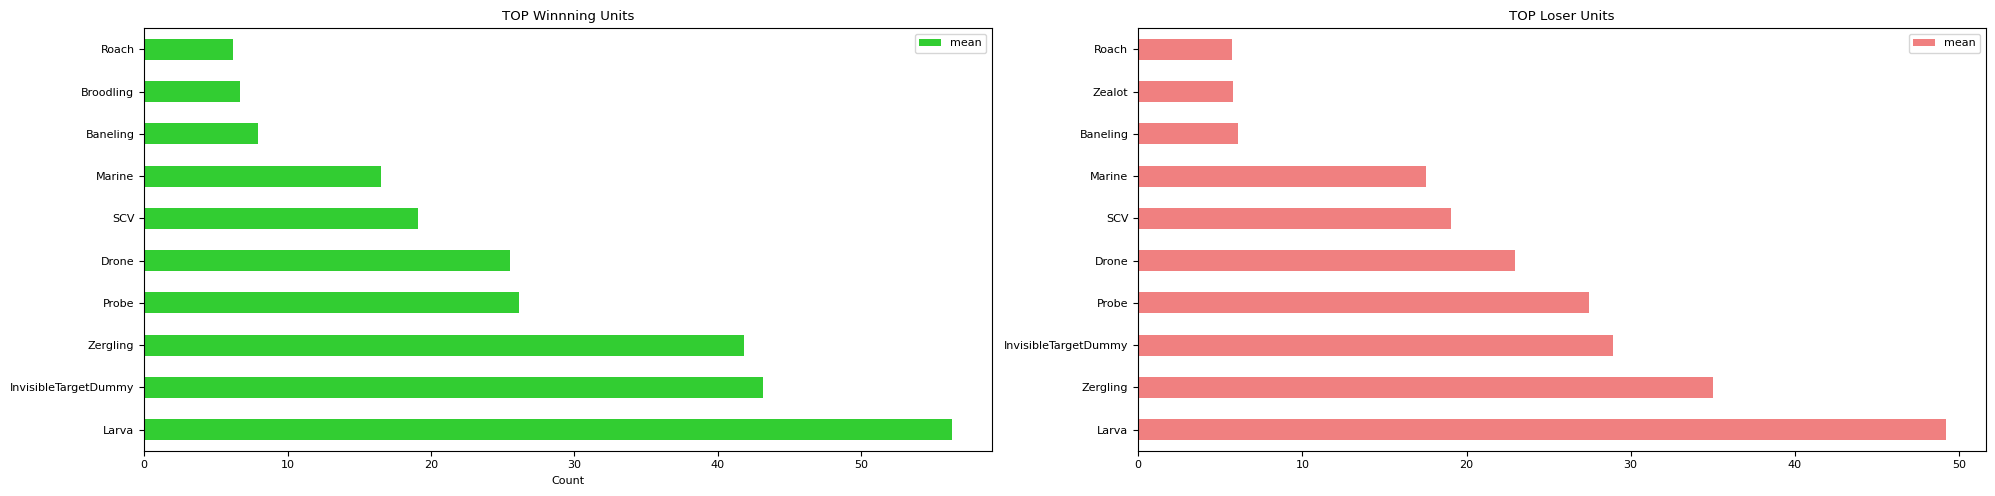

In [487]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) 


winner_cols[['mean']][:10].plot(kind='barh', ax=axs[0], color='limegreen')
axs[0].set_title('TOP Winnning Units')
axs[0].set_xlabel('Count')

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) 


loser_cols[['mean']][:10].plot(kind='barh', ax=axs[1], color='lightcoral')
axs[1].set_title('TOP Loser Units')
axs[0].set_xlabel('Count')

plt.tight_layout()
plt.show()


In [488]:
diff_col = winner_cols.reset_index()[['index', 'mean']].merge(loser_cols.reset_index()[['index', 'mean']], on='index', how='left')
diff_col['diff'] = diff_col['mean_x'] - diff_col['mean_y']
diff_col.sort_values('diff', ascending=False)[:20]

,index,mean_x,mean_y,diff
1,InvisibleTargetDummy,43.173,28.927,14.246
0,Larva,56.303,49.188,7.115
2,Zergling,41.855,35.032,6.823
13,BroodlingEscort,5.548,1.982,3.566
4,Drone,25.499,22.926,2.573
8,Broodling,6.661,4.208,2.453
7,Baneling,7.920,6.064,1.856
14,CreepTumorBurrowed,4.686,3.073,1.613
11,Overlord,5.801,4.986,0.815
25,Changeling,1.311,0.800,0.511


In [489]:
diff_col.sort_values('diff', ascending=False)['index'].values[:8]

array(['InvisibleTargetDummy', 'Larva', 'Zergling', 'BroodlingEscort',
       'Drone', 'Broodling', 'Baneling', 'CreepTumorBurrowed'],
      dtype=object)

#### Creating Winning Cols

In [490]:
create_unit_cols = ['InvisibleTargetDummy', 'Larva', 'Zergling', 'BroodlingEscort', 'Drone', 'Broodling', 'Baneling', 'CreepTumorBurrowed']

player_1_units_counts = df['player_1_units'].apply(parse_and_count_units)
player_2_units_counts = df['player_2_units'].apply(parse_and_count_units)

p1_c = pd.json_normalize(player_1_units_counts).fillna(0)
p1_c = p1_c[[col for col in create_unit_cols if col in p1_c.columns]]
p1_c.columns = [f'p1_{col}' for col in p1_c.columns]

p2_c = pd.json_normalize(player_2_units_counts).fillna(0)
p2_c = p2_c[[col for col in create_unit_cols if col in p2_c.columns]]
p2_c.columns = [f'p2_{col}' for col in p2_c.columns]

p_unit_counts = pd.concat([p1_c, p2_c], axis=1).fillna(0)
df[p_unit_counts.columns] = p_unit_counts.values



In [491]:
for i,j in zip(p1_c.columns, p2_c.columns):
    temp_unit = i.split('_')[-1]
    df[temp_unit] = df[i] - df[j]

### Numerical & Categorical Column

In [492]:
##Selecting numerical features
numerical_data = df.select_dtypes(include='number')
numerical_features=numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 48 numerical features: 

['winner', 'build', 'p1_unique_units', 'p2_unique_units', 'unique_diff', 'p1_unit_count', 'p2_unit_count', 'unit_count_diff', 'p1_SUPPLY_UNITS', 'p1_WORKER_UNITS', 'p1_ARMY_UNITS', 'p1_ARMY_AIR', 'p1_VESPENE_UNITS', 'p1_TECH_UNITS', 'p1_GROUND_UNITS', 'p1_AIR_UNITS', 'p2_SUPPLY_UNITS', 'p2_WORKER_UNITS', 'p2_ARMY_UNITS', 'p2_ARMY_AIR', 'p2_VESPENE_UNITS', 'p2_TECH_UNITS', 'p2_GROUND_UNITS', 'p2_AIR_UNITS', 'p1_InvisibleTargetDummy', 'p1_Larva', 'p1_Zergling', 'p1_BroodlingEscort', 'p1_Drone', 'p1_Broodling', 'p1_Baneling', 'p1_CreepTumorBurrowed', 'p2_InvisibleTargetDummy', 'p2_Larva', 'p2_Zergling', 'p2_BroodlingEscort', 'p2_Drone', 'p2_Broodling', 'p2_Baneling', 'p2_CreepTumorBurrowed', 'InvisibleTargetDummy', 'Larva', 'Zergling', 'BroodlingEscort', 'Drone', 'Broodling', 'Baneling', 'CreepTumorBurrowed']


In [493]:
#Selecting categoricalfeatures
categorical_data=df.select_dtypes(include= 'object')
categorical_features=categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} numerical features:', '\n')
print(categorical_features)

There are 8 numerical features: 

['map', 'player_1_units', 'player_1', 'player_2_units', 'player_2', 'path', 'p1_embedding', 'p2_embedding']


In [494]:
numerical_data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
winner,4439.0,1.49,0.50,1.0,1.0,1.0,2.0,2.0
build,4439.0,84436.11,3578.93,78285.0,82893.0,84643.0,88500.0,89165.0
p1_unique_units,4439.0,21.68,15.21,2.0,8.0,13.0,37.0,59.0
p2_unique_units,4439.0,20.09,16.28,0.0,6.0,9.0,36.0,61.0
unique_diff,4439.0,1.59,3.95,-19.0,0.0,2.0,4.0,16.0
p1_unit_count,4439.0,371.09,622.78,15.0,101.0,212.0,405.0,12709.0
p2_unit_count,4439.0,278.18,643.93,0.0,75.0,129.0,247.0,12856.0
unit_count_diff,4439.0,92.90,822.28,-12246.0,-16.0,19.0,171.0,11939.0
p1_SUPPLY_UNITS,4439.0,9.94,10.63,0.0,0.0,7.0,18.0,60.0
p1_WORKER_UNITS,4439.0,79.71,33.03,12.0,58.0,78.0,99.0,269.0


In [495]:
categorical_data.describe(include='object').T


,count,unique,top,freq
map,4439,92,Romanticide LE,378
player_1_units,4439,4425,"[BeaconArmy, BeaconDefend, BeaconAttack, Beaco...",2
player_1,4439,321,Reynor,112
player_2_units,4439,4419,"[Nexus, Probe, Probe, Probe, Probe, Probe, Pro...",3
player_2,4439,324,ShoWTimE,118
path,4439,4435,replay_data\DH SC2 Masters - Atlanta 2022 Onli...,2
p1_embedding,4439,4439,"[0.0102319783, -0.0896995589, -0.0315713435, 0...",1
p2_embedding,4439,4439,"[0.0056394353000000005, -0.0848710686, -0.0358...",1


In [496]:
create_unit_cols = ['InvisibleTargetDummy', 'Larva', 'Zergling', 'BroodlingEscort', 'Drone', 'Broodling', 'Baneling', 'CreepTumorBurrowed']
create_unit_cols = [f'p1_{col}' for col in create_unit_cols]

In [497]:
create_unit_cols

['p1_InvisibleTargetDummy',
 'p1_Larva',
 'p1_Zergling',
 'p1_BroodlingEscort',
 'p1_Drone',
 'p1_Broodling',
 'p1_Baneling',
 'p1_CreepTumorBurrowed']

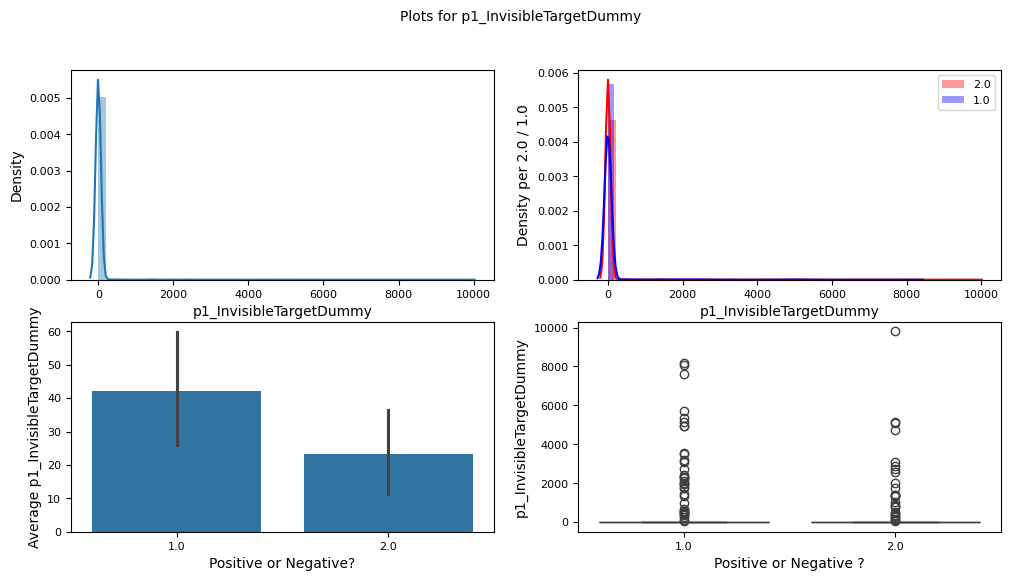

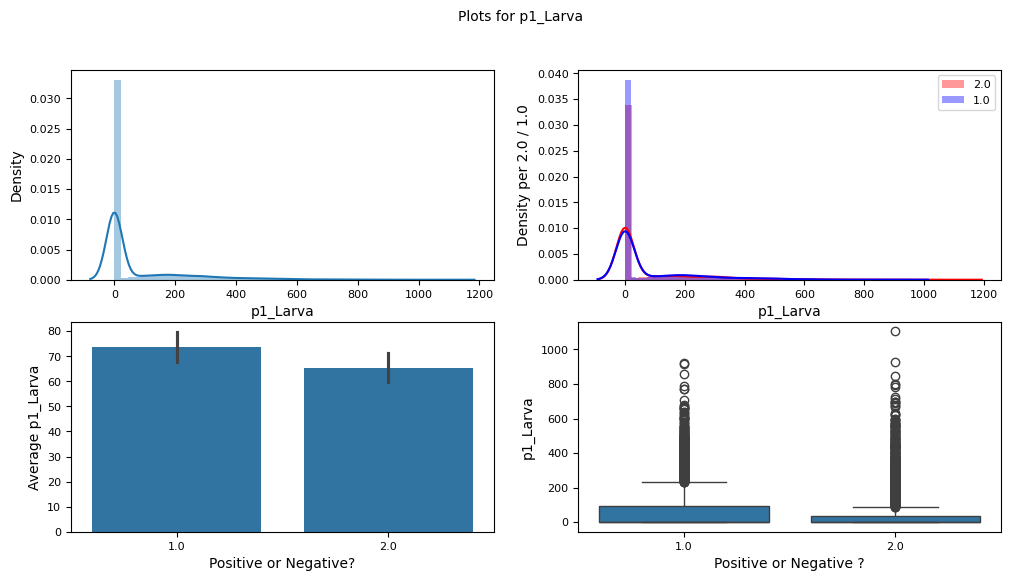

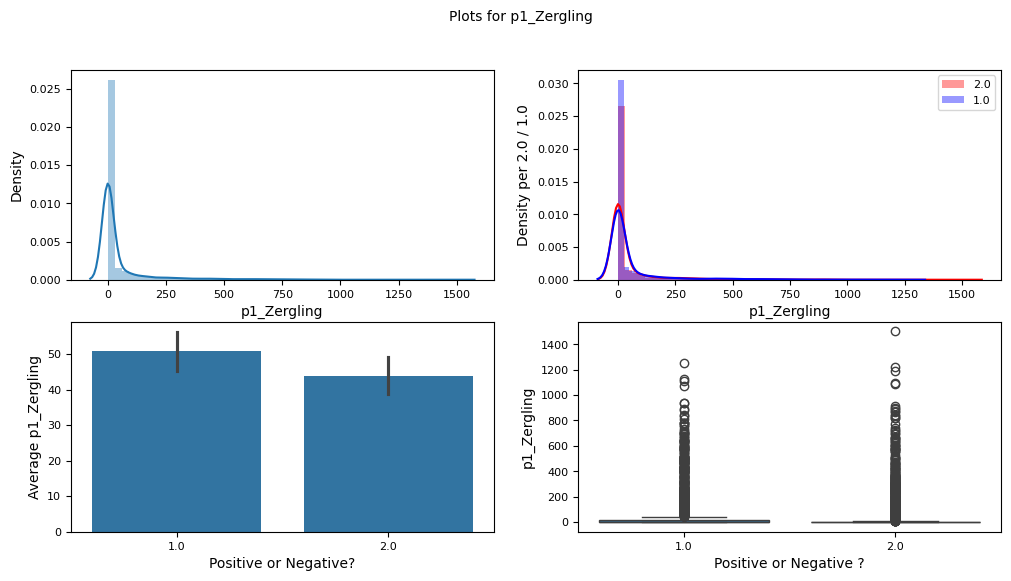

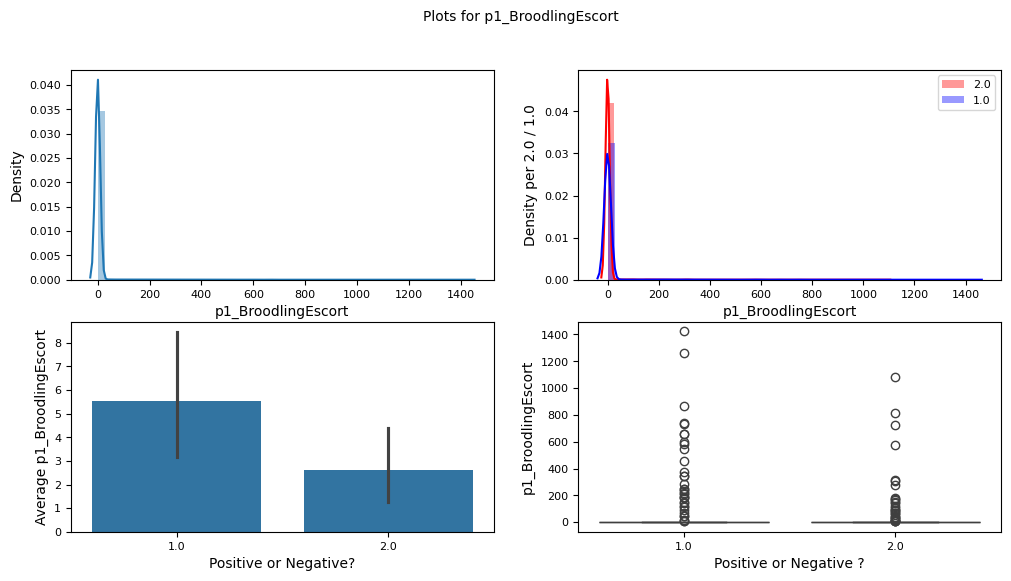

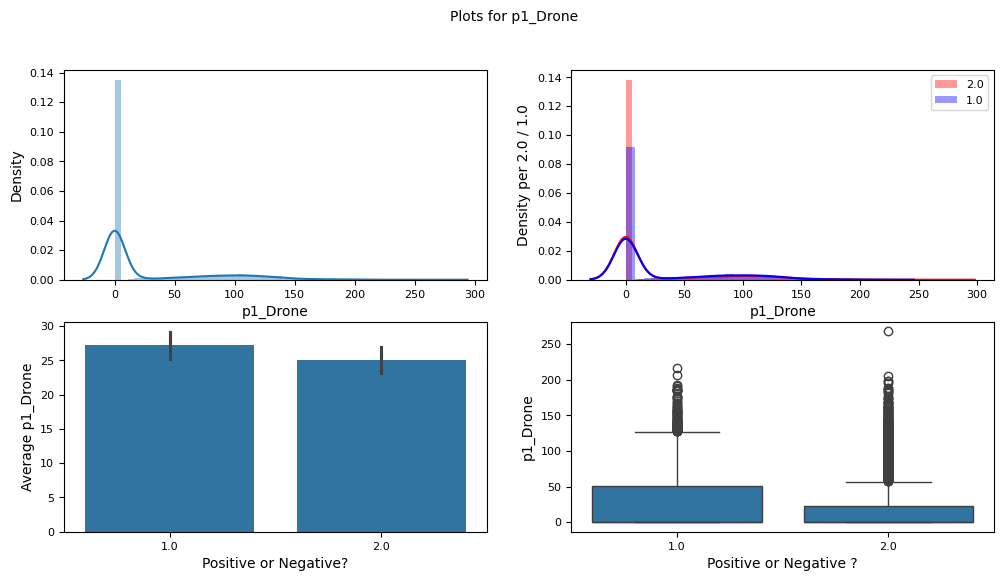

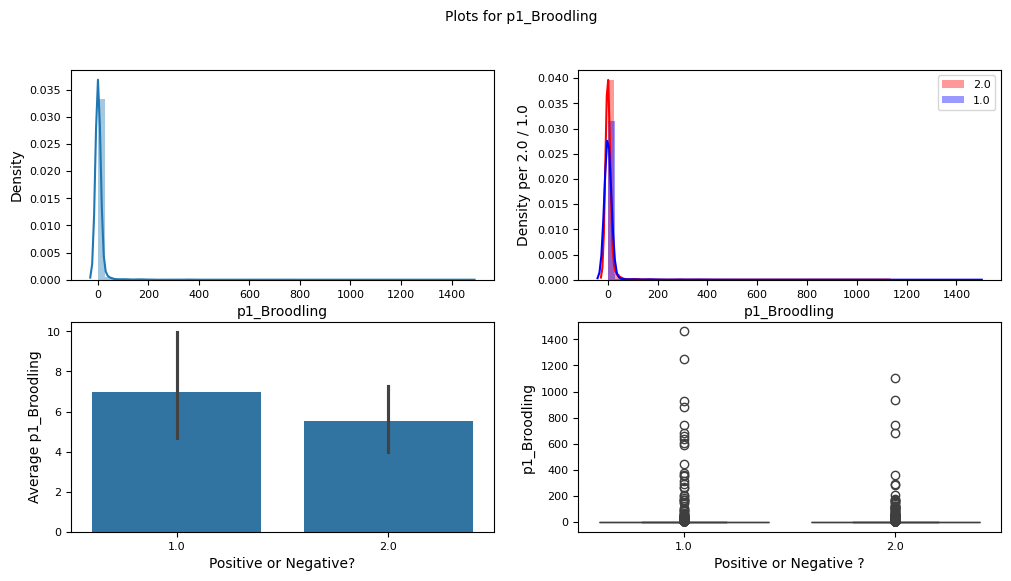

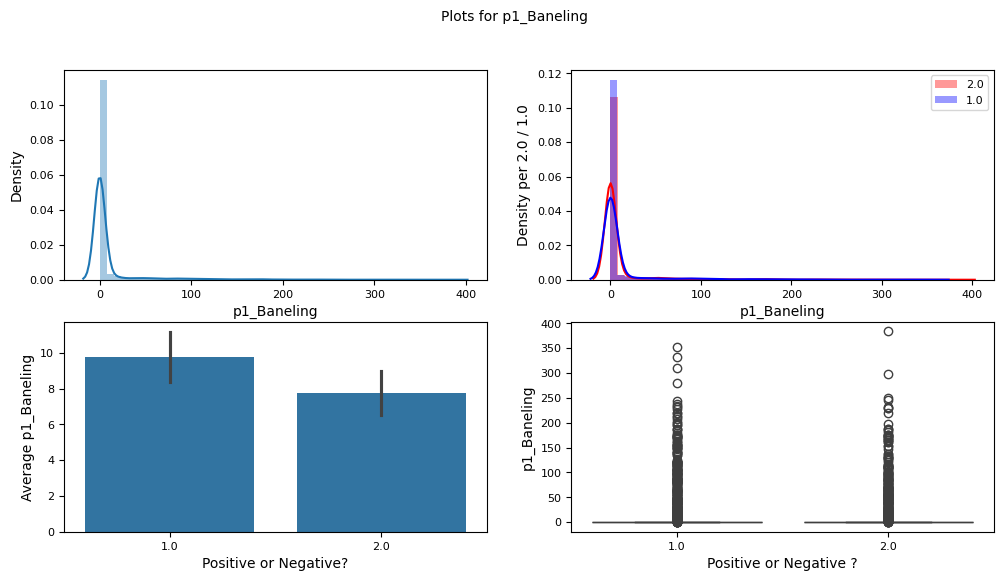

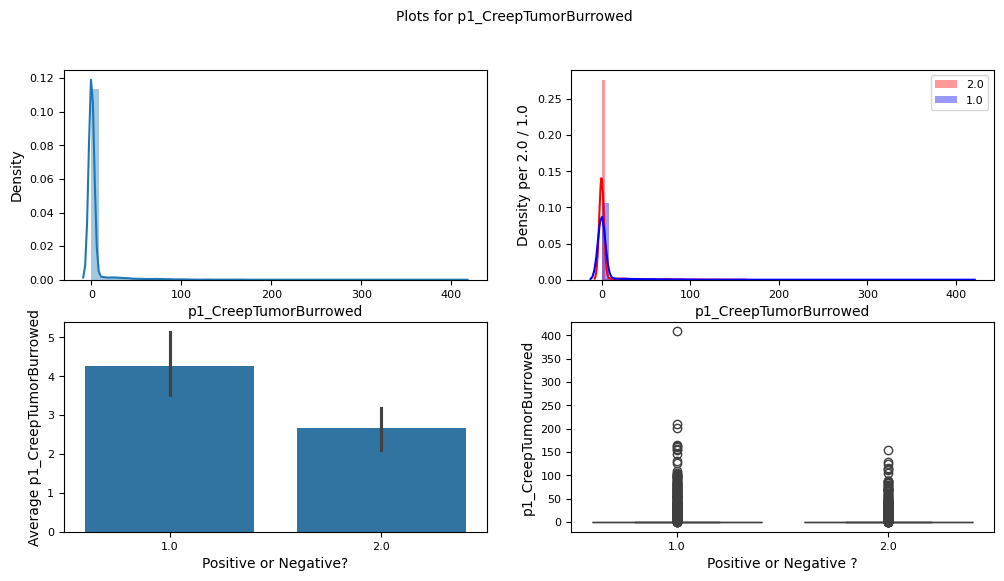

In [498]:
plot_numeric(df, create_unit_cols, 'winner')

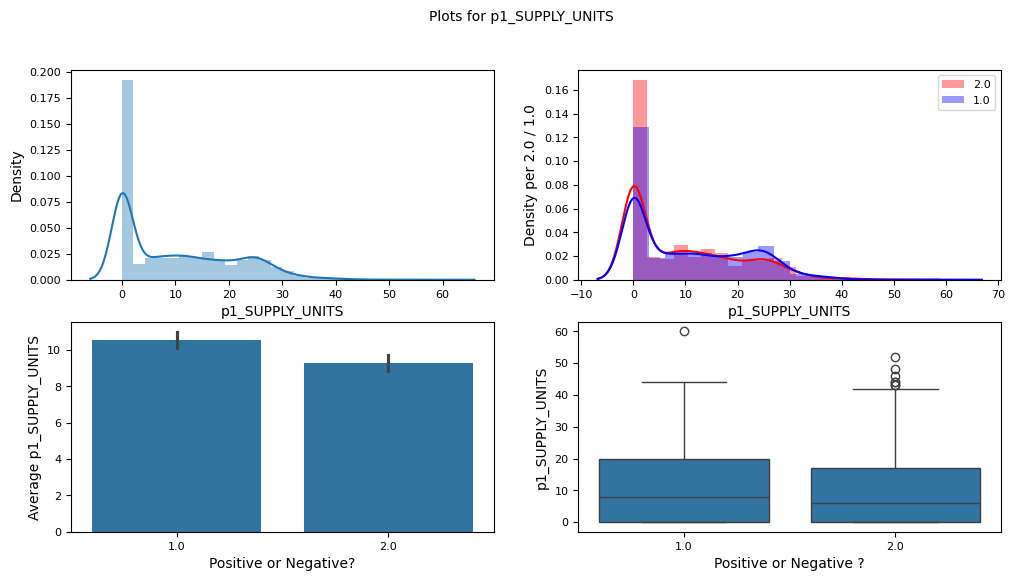

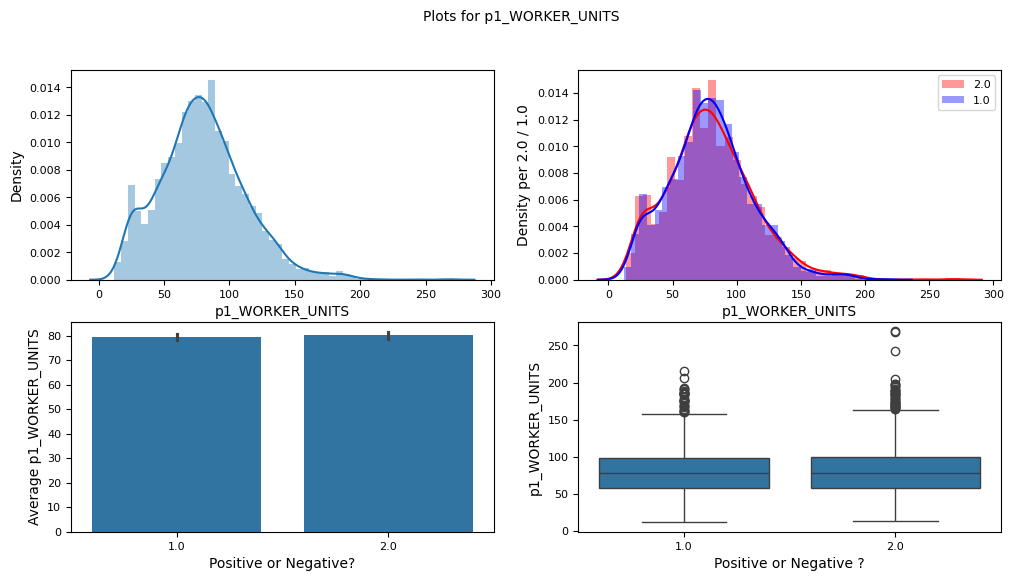

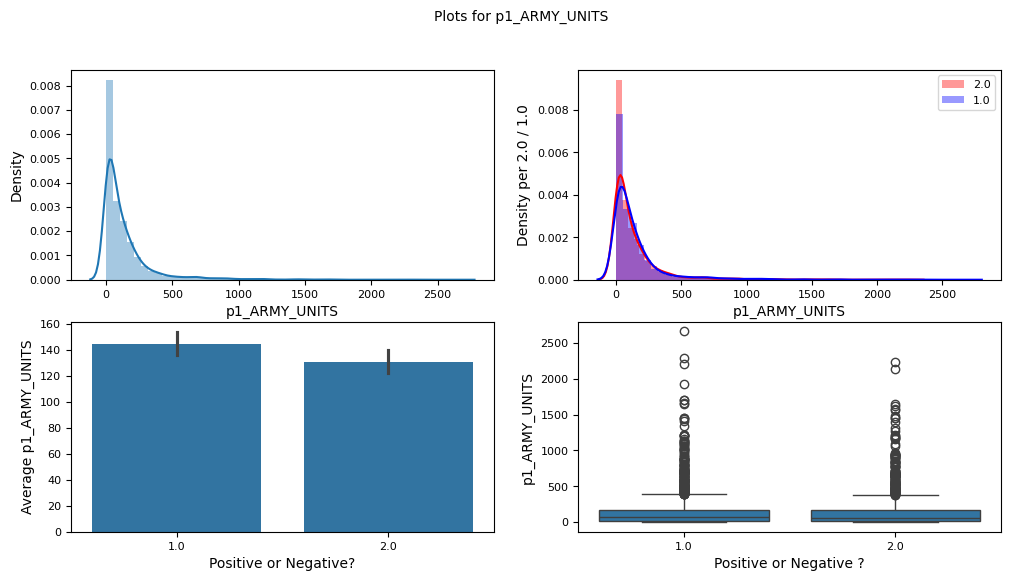

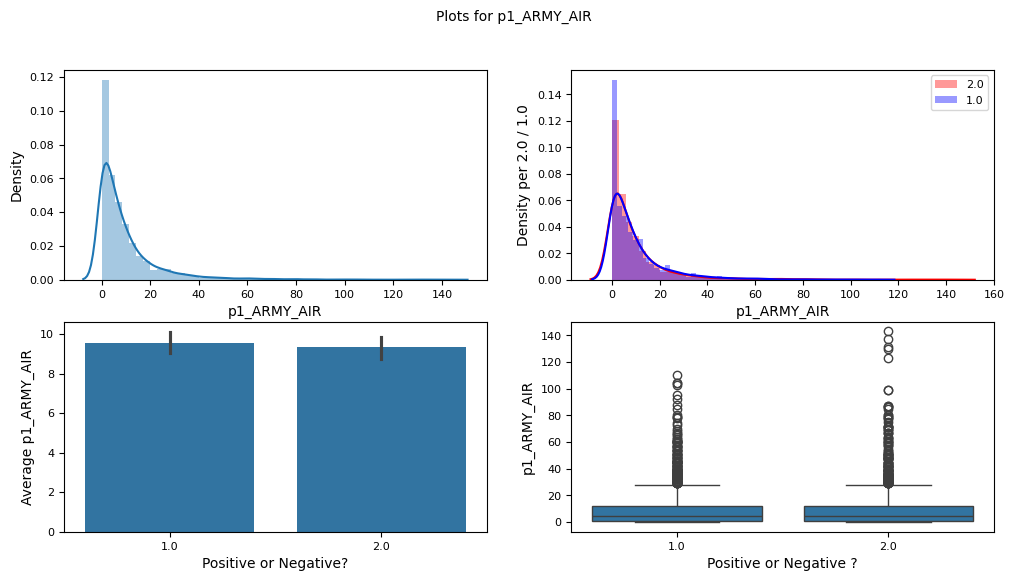

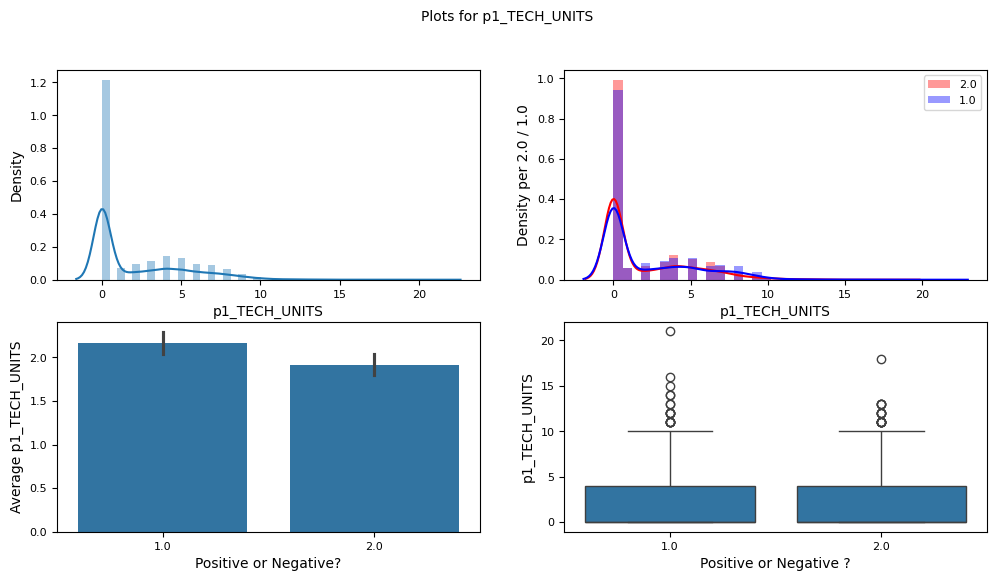

In [499]:
test_cols = ['p1_SUPPLY_UNITS',
 'p1_WORKER_UNITS',
 'p1_ARMY_UNITS',
 'p1_ARMY_AIR',
 'p1_TECH_UNITS']
plot_numeric(df, test_cols, 'winner')

In [247]:
def correlationMap(df, target) :
    """ 
    Correlation Heatmap
    Inputs : 
        df -- dataframe containing features to plot
        target -- target column name
     """
    classes = df[target].unique()
    if df[target].dtype == 'O' :
        df[target+'_id'] = (df[target]== classes[0]).astype(int) #encode string target 
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corr, vmax=.8,annot=True, square=True)
    if df[target].dtype == 'O' :
        df.drop([target+'_id'], axis=1, inplace=True)
    # fix for matplotlib bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # Gets the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()


In [379]:
df['unique_diff'].values

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

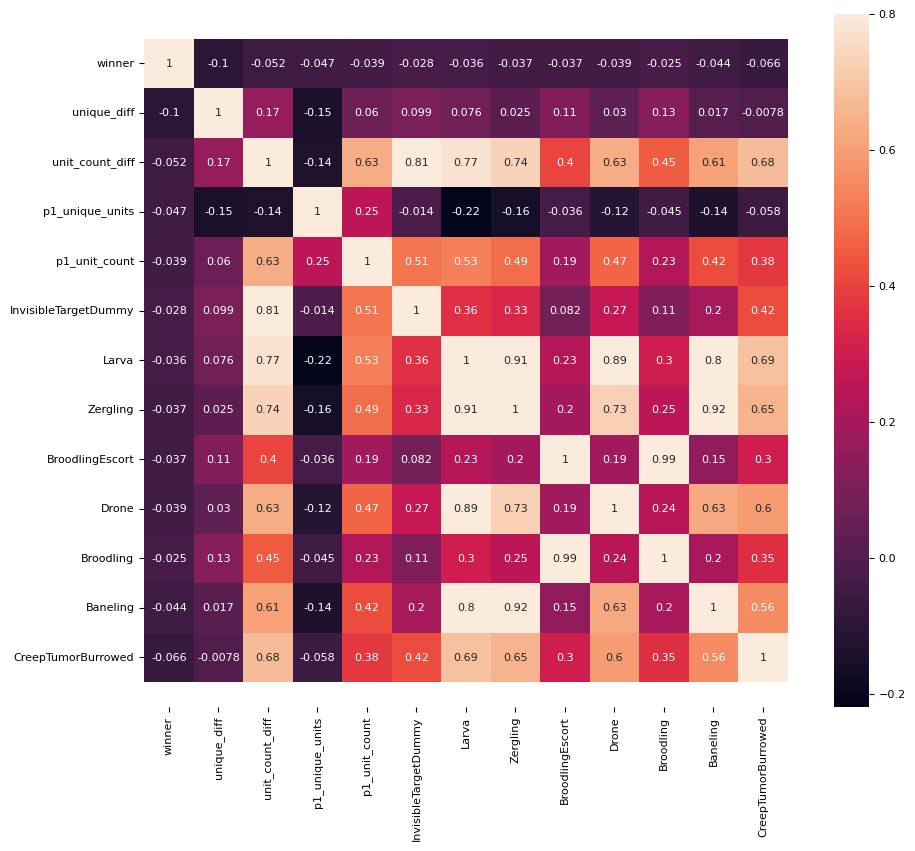

In [408]:
test_cols = ['winner',
 'unique_diff',
 'unit_count_diff',
 'p1_unique_units',
 'p1_unit_count',
 'InvisibleTargetDummy', 'Larva', 'Zergling', 'BroodlingEscort', 'Drone', 'Broodling', 'Baneling', 'CreepTumorBurrowed']
correlationMap(df[test_cols],'winner')

## Players Profiling

In [218]:
players_df = pd.DataFrame(pd.concat([df['player_1'], df['player_2']], axis=0).value_counts())
winner_players = pd.concat([df[df['winner'] == 1]['player_1'], df[df['winner'] == 2]['player_2']], axis=0).value_counts()

winner_players = pd.DataFrame(winner_players).reset_index()
players_df = winner_players.merge(players_df.reset_index(), on='index', how='left')
players_df.columns = ['name', 'win_count', 'match_count']
players_df['win_ratio'] = 100*(players_df['win_count'] / players_df['match_count'])

players_df = players_df.round(2).sort_values(by='match_count', ascending=False)
players_df.set_index('name', inplace=True)

In [219]:
players_df.describe().round(2)

,win_count,match_count,win_ratio
count,307.00,307.00,307.00
mean,14.46,28.45,46.01
std,18.15,29.73,16.69
min,1.00,1.00,11.11
25%,3.00,9.00,33.33
50%,8.00,18.00,45.71
75%,17.00,35.00,57.48
max,127.00,203.00,100.00


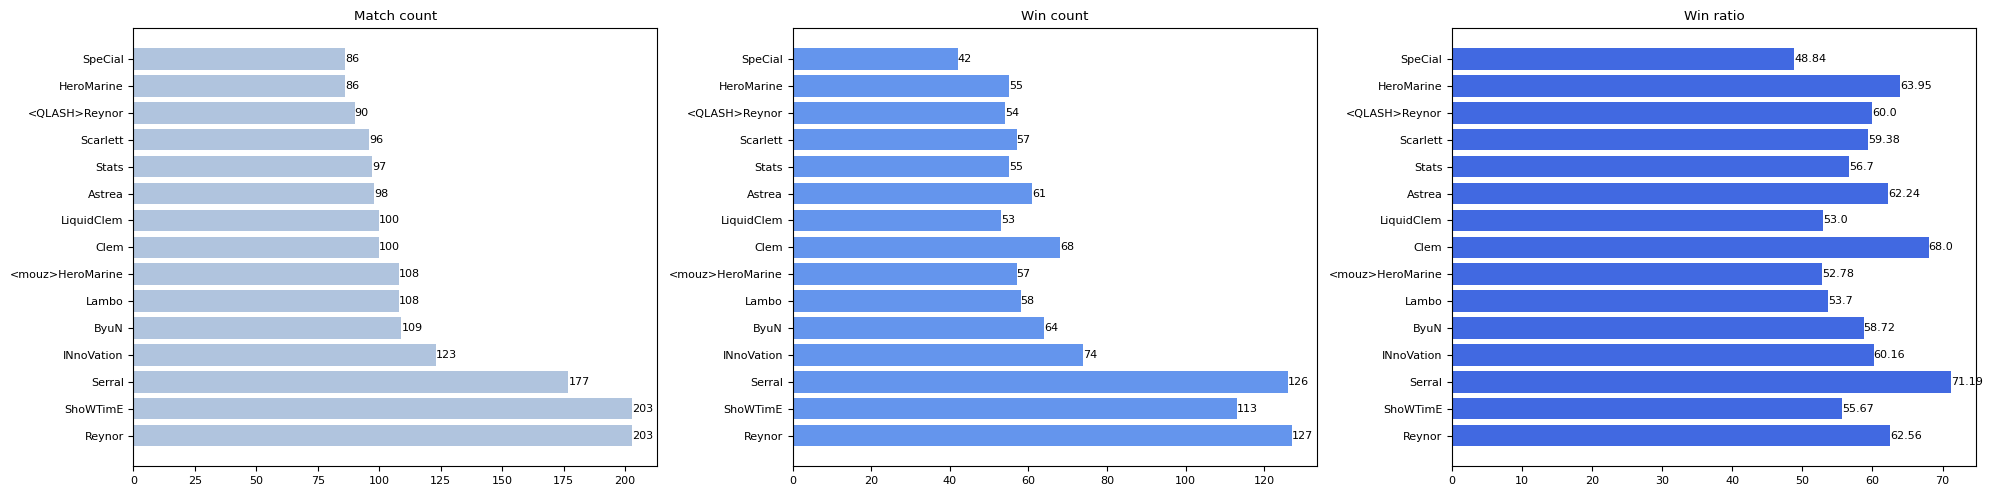

In [220]:
p1 = ['match_count', 'win_count', 'win_ratio']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5)) 
axs = axs.flatten() 
# colors = {'Winner': 'forestgreen', 'Loser': 'lightcoral'}
colors = ['lightsteelblue', 'cornflowerblue', 'royalblue']

for idx, i in enumerate(p1):
    ax = axs[idx]
    type = i.replace('_', ' ').capitalize()
    bars = ax.barh(players_df.index[:15], players_df[i].values[:15] , color=colors[idx ])
    ax.set_title(type)
    
    # for bar in bars:
    #     height = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width}', ha='left', va='center')
        
plt.tight_layout()
plt.show()


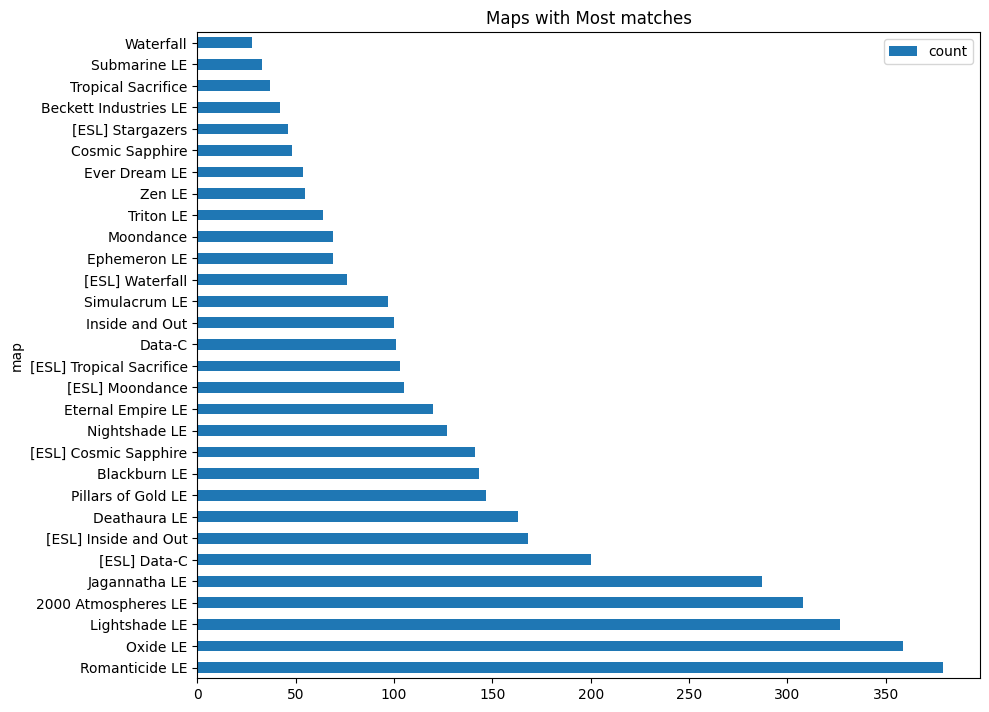

In [199]:
players_df = pd.DataFrame(df['map'].value_counts())
players_df[:30].plot(kind='barh', figsize=(10,7))
plt.tight_layout()
plt.title("Maps with Most matches")
plt.show()

In [500]:
map_count = df.groupby('map').count()[['player_1_units']]
map_count = map_count.sort_values(by='player_1_units', ascending=False)

In [501]:
map_count[map_count['player_1_units'] > 30].index

Index(['Romanticide LE', 'Oxide LE', 'Lightshade LE', '2000 Atmospheres LE',
       'Jagannatha LE', '[ESL] Data-C', '[ESL] Inside and Out', 'Deathaura LE',
       'Pillars of Gold LE', 'Blackburn LE', '[ESL] Cosmic Sapphire',
       'Nightshade LE', 'Eternal Empire LE', '[ESL] Moondance',
       '[ESL] Tropical Sacrifice', 'Data-C', 'Inside and Out', 'Simulacrum LE',
       '[ESL] Waterfall', 'Moondance', 'Ephemeron LE', 'Triton LE', 'Zen LE',
       'Ever Dream LE', 'Cosmic Sapphire', '[ESL] Stargazers',
       'Beckett Industries LE', 'Tropical Sacrifice', 'Submarine LE'],
      dtype='object', name='map')

In [502]:
map_names = ['Romanticide LE', 'Oxide LE', 'Lightshade LE', '2000 Atmospheres LE',
       'Jagannatha LE', '[ESL] Data-C', '[ESL] Inside and Out', 'Deathaura LE',
       'Pillars of Gold LE', 'Blackburn LE', '[ESL] Cosmic Sapphire',
       'Nightshade LE', 'Eternal Empire LE', '[ESL] Moondance',
       '[ESL] Tropical Sacrifice', 'Data-C', 'Inside and Out', 'Simulacrum LE',
       '[ESL] Waterfall', 'Moondance', 'Ephemeron LE', 'Triton LE', 'Zen LE',
       'Ever Dream LE', 'Cosmic Sapphire', '[ESL] Stargazers',
       'Beckett Industries LE', 'Tropical Sacrifice', 'Submarine LE']

In [506]:
len(map_names)

29

In [503]:
map_vals = []
for map in df['map'].values:
    if map not in map_names:
        map_vals.append('others')
    else:
        map_vals.append(map)
    

In [504]:
df['map_new'] = map_vals

In [505]:
df['map_new'].value_counts()

map_new
others                      475
Romanticide LE              378
Oxide LE                    357
Lightshade LE               327
2000 Atmospheres LE         308
Jagannatha LE               286
[ESL] Data-C                200
[ESL] Inside and Out        168
Deathaura LE                163
Pillars of Gold LE          147
Blackburn LE                143
[ESL] Cosmic Sapphire       141
Nightshade LE               127
Eternal Empire LE           120
[ESL] Moondance             105
[ESL] Tropical Sacrifice    103
Data-C                      101
Inside and Out              100
Simulacrum LE                97
[ESL] Waterfall              76
Ephemeron LE                 69
Moondance                    69
Triton LE                    64
Zen LE                       55
Ever Dream LE                54
Cosmic Sapphire              48
[ESL] Stargazers             46
Beckett Industries LE        42
Tropical Sacrifice           37
Submarine LE                 33
Name: count, dtype: int64

In [472]:
df['map'].value_counts()

map
others                      545
Romanticide LE              378
Oxide LE                    357
Lightshade LE               327
2000 Atmospheres LE         308
Jagannatha LE               286
[ESL] Data-C                200
[ESL] Inside and Out        168
Deathaura LE                163
Pillars of Gold LE          147
Blackburn LE                143
[ESL] Cosmic Sapphire       141
Nightshade LE               127
Eternal Empire LE           120
[ESL] Moondance             105
[ESL] Tropical Sacrifice    103
Data-C                      101
Inside and Out              100
Simulacrum LE                97
[ESL] Waterfall              76
Ephemeron LE                 69
Moondance                    69
Triton LE                    64
Zen LE                       55
Ever Dream LE                54
Cosmic Sapphire              48
[ESL] Stargazers             46
Beckett Industries LE        42
Name: count, dtype: int64

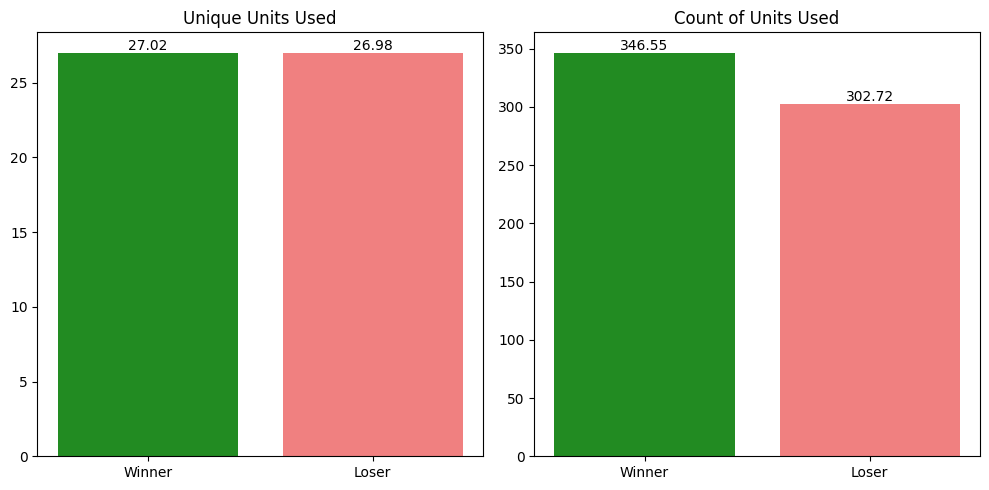

In [183]:
p1 = ['p1_unique_units', 'p1_unit_count']
p2 = [ 'p2_unique_units', 'p2_unit_count']

fig, axs = plt.subplots(nrows=math.ceil(len(p1)/2), ncols=2, figsize=(10, 5)) 
axs = axs.flatten() 
colors = {'Winner': 'forestgreen', 'Loser': 'lightcoral'}

for idx, (i, j) in enumerate(zip(p1, p2)):
    winner = pd.concat([df[df['winner'] == 1][i], df[df['winner'] == 2][j]], axis=0).mean().round(2)
    loser = pd.concat([df[df['winner'] == 2][i], df[df['winner'] == 1][j]], axis=0).mean().round(2)
    ax = axs[idx]
    # type = i.split('_')[1]
    
    if idx == 0:
        type = "Unique Units Used"
    else:
        type = "Count of Units Used"
    
    bars = ax.bar(['Winner', 'Loser'], [winner, loser], color=[colors['Winner'], colors['Loser']])
    ax.set_title(type)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')


plt.tight_layout()
plt.show()

# winner_unique_units = pd.concat([df[df['winner'] == 1]['p1_unique_units'], df[df['winner'] == 2]['p2_unique_units']], axis=0).mean()
# loser_unique_units = pd.concat([df[df['winner'] == 2]['p1_unique_units'], df[df['winner'] == 1]['p2_unique_units']], axis=0).mean()

# winner_unit_counts = pd.concat([df[df['winner'] == 1]['p1_unit_count'], df[df['winner'] == 2]['p2_unit_count']], axis=0).mean()
# loser_unit_counts = pd.concat([df[df['winner'] == 2]['p1_unit_count'], df[df['winner'] == 1]['p2_unit_count']], axis=0).mean()

In [63]:
pd.concat([df[df['winner'] == 1]['p1_SUPPLY_UNITS'], df[df['winner'] == 2]['p2_SUPPLY_UNITS']], axis=0).mean()

10.19621536382068

## UNIT DISTRIBUTION

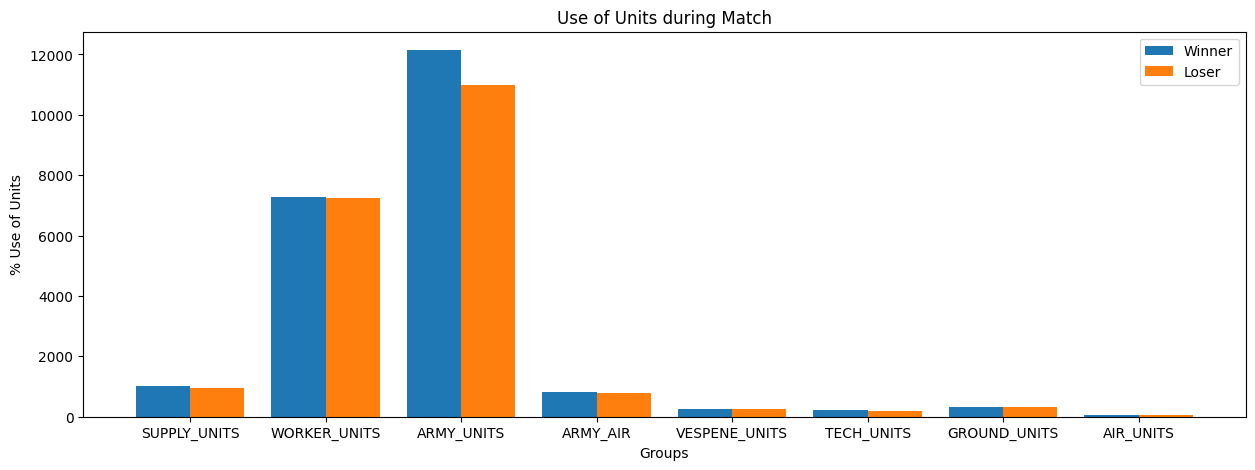

In [59]:
# Function to parse the string representation of lists and count unit types

# player_1_units_counts = df['player_1_units'].apply(parse_and_count_units)
# player_2_units_counts = df['player_2_units'].apply(parse_and_count_units)

all_unit_counts = pd.concat([player_1_units_counts, player_2_units_counts])
all_unique_units = set(unit for counts in all_unit_counts for unit in counts)

player_1_cols = [f'player_1_{unit}' for unit in all_unique_units]
player_2_cols = [f'player_2_{unit}' for unit in all_unique_units]
new_cols_df = pd.DataFrame(0, index=df.index, columns=player_1_cols + player_2_cols)
df_cleaned = pd.concat([df, new_cols_df], axis=1)

p1_unit_types = pd.json_normalize(player_1_units_counts.apply(count_unit_type))
p1_unit_types.columns = [f'p1_{col}' for col in p1_unit_types]

p2_unit_types = pd.json_normalize(player_2_units_counts.apply(count_unit_type))
p2_unit_types.columns = [f'p2_{col}' for col in p2_unit_types]

p1_df= df[df['winner'] == 1][p1_unit_types.columns]
p1_df.columns = [col.replace('p1_', '') for col in p1_df.columns]
p2_df = df[df['winner'] == 2][p2_unit_types.columns]
p2_df.columns = [col.replace('p2_', '') for col in p2_df.columns]

win_df = pd.concat([p1_df, p2_df], axis=0).mean()

p1_df= df[df['winner'] == 2][p1_unit_types.columns]
p1_df.columns = [col.replace('p1_', '') for col in p1_df.columns]
p2_df = df[df['winner'] == 1][p2_unit_types.columns]
p2_df.columns = [col.replace('p2_', '') for col in p2_df.columns]

lose_df = pd.concat([p1_df, p2_df], axis=0).mean()
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(win_df.index)) - 0.2, win_df.values*100, 0.4, label = 'Winner') 
plt.bar(np.arange(len(lose_df.index)) + 0.2, lose_df.values*100, 0.4, label = 'Loser') 

plt.xticks(np.arange(len(win_df.index)), win_df.index) 
plt.xlabel("Groups") 
plt.ylabel("% Use of Units") 
plt.title("Use of Units during Match") 
plt.legend() 
plt.show() 

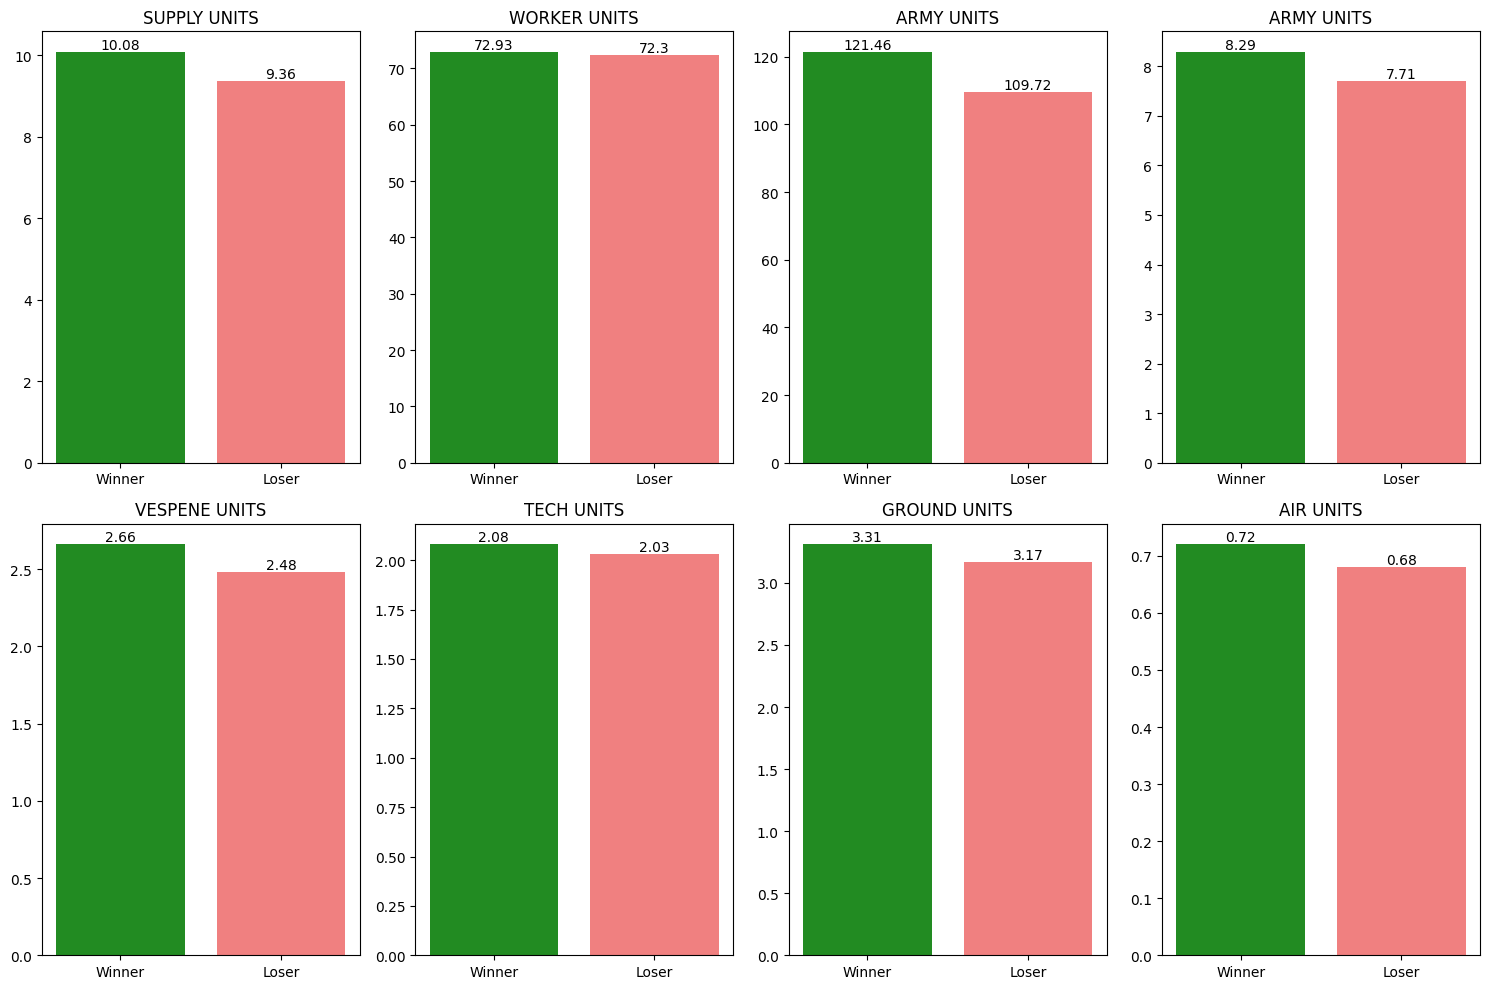

In [176]:
p1 = ['p1_SUPPLY_UNITS', 'p1_WORKER_UNITS', 'p1_ARMY_UNITS', 'p1_ARMY_AIR', 'p1_VESPENE_UNITS', 'p1_TECH_UNITS', 'p1_GROUND_UNITS', 'p1_AIR_UNITS']
p2 = [ 'p2_SUPPLY_UNITS', 'p2_WORKER_UNITS', 'p2_ARMY_UNITS', 'p2_ARMY_AIR', 'p2_VESPENE_UNITS', 'p2_TECH_UNITS', 'p2_GROUND_UNITS', 'p2_AIR_UNITS']

fig, axs = plt.subplots(nrows=math.ceil(len(p1)/4), ncols=4, figsize=(15, 10)) 
axs = axs.flatten() 
colors = {'Winner': 'forestgreen', 'Loser': 'lightcoral'}

for idx, (i, j) in enumerate(zip(p1, p2)):
    winner = pd.concat([df[df['winner'] == 1][i], df[df['winner'] == 2][j]], axis=0).mean().round(2)
    loser = pd.concat([df[df['winner'] == 2][i], df[df['winner'] == 1][j]], axis=0).mean().round(2)
    ax = axs[idx]
    type = i.split('_')[1] + ' UNITS'
    bars = ax.bar(['Winner', 'Loser'], [winner, loser], color=[colors['Winner'], colors['Loser']])
    ax.set_title(type)


    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')


plt.tight_layout()
plt.show()
